# How to perform intensity image registration with manual initialisation.

The goal here is not to explain how to manually define landmarks (for that look [here](how_to-manual_landmarks_definition.ipynb)) but to show how to use `pointmatching` and `blockmatching` algorithms to perform *intensity image registration with manual initialisation*.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from timagetk.io import imread
from timagetk.io.image import _image_from_url
from timagetk.algorithms.trsf import apply_trsf
from timagetk.algorithms.trsf import compose_trsf
from timagetk.algorithms.blockmatching import blockmatching
from timagetk.algorithms.pointmatching import pointmatching

/home/aurele/Soft/timagetk/src/timagetk/components/labelled_image.py:32: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Loading the shared data

In [3]:
file_urls = [
    "https://zenodo.org/record/7151866/files/090223-p58-flo-top.lsm",
    "https://zenodo.org/record/7151866/files/090223-p58-flo-tilt1.lsm",
    "https://zenodo.org/record/7151866/files/090223-p58-flo-tilt2.lsm"
]
file_hashs = [
    "5548917d3d1490200d0d56cbb31c0d35",
    "fa004a84100fcd5ff1d2f9d7c5cbda30",
    "006bf3bacb667eb72d0fb9a6419edcc1"
]

In [4]:
fnames = [_image_from_url(url ,hash_value=md5_hash, hash_method='md5') for url, md5_hash in zip(file_urls, file_hashs)]

### Intensity images

In [5]:
ref_img = imread(fnames[0])
flo_img = imread(fnames[1])

### Manually defined landmarks

In [6]:
ref_pts = np.loadtxt('p58_t0_reference_ldmk-01.txt')
flo_pts = np.loadtxt('p58_t0_floating_ldmk-01.txt')

## Displaying the shared data

The landmarks have been manually defined on a top-view projection map, so we start by computing the intensity image projections (and associated altitude maps):

In [7]:
from timagetk.algorithms.reconstruction import image_surface_projection

ref_proj, ref_alti = image_surface_projection(ref_img, threshold=np.percentile(ref_img, 60), orientation=1)
flo_proj, flo_alti = image_surface_projection(flo_img, threshold=np.percentile(flo_img, 60), orientation=1)

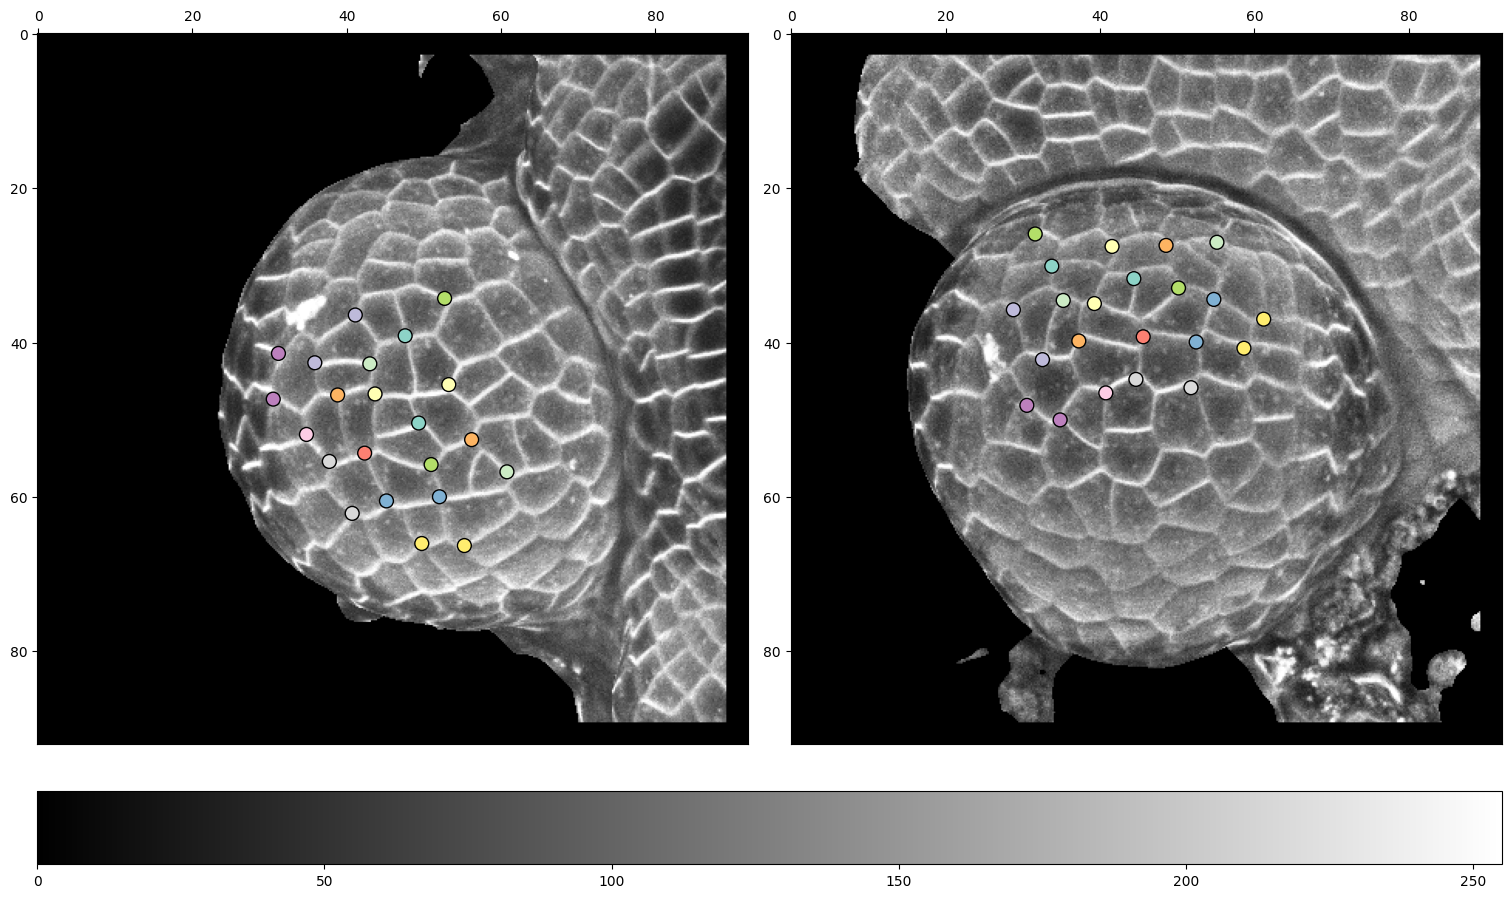

In [8]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
# Create two panels
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ref_ax = fig.add_subplot(gs[0, 0])
flo_ax = fig.add_subplot(gs[0, 1])
# Add the projection map as images:
mpl_extent = {}
for idx, image in zip(['reference', 'floating'], [ref_proj, flo_proj]):
        vxs = image.get_voxelsize()
        im_extent = image.get_extent()
        mpl_extent[idx] = (-vxs[0]/2, im_extent[0]+vxs[0]/2, im_extent[1]+vxs[1]/2, -vxs[1]/2)

images = []
images.append(ref_ax.imshow(ref_proj, cmap='gray', extent=mpl_extent['reference']))
images.append(flo_ax.imshow(flo_proj, cmap='gray', extent=mpl_extent['floating']))
ref_ax.xaxis.tick_top()
flo_ax.xaxis.tick_top()
# Add the landmarks points:
px, py, c = np.array([(p[0], p[1], n) for n, p in enumerate(ref_pts)]).T
ref_ax.scatter(px, py, c=c, cmap='Set3', ec='k', s=100)
px, py, c = np.array([(p[0], p[1], n) for n, p in enumerate(flo_pts)]).T
flo_ax.scatter(px, py, c=c, cmap='Set3', ec='k', s=100)

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
# Add a colorbar at the bottom
_ = fig.colorbar(images[0], ax=[ref_ax, flo_ax], orientation='horizontal', fraction=.1)

## Initial transformation from manually defined landmarks

In [9]:
rigid_init_trsf = pointmatching(flo_pts, ref_pts, template_img=ref_img, method='rigid', real=True)

In [10]:
registered_image = apply_trsf(flo_img, trsf=rigid_init_trsf, template_img=ref_img, interpolation='linear')

In [11]:
reg_proj, reg_alti = image_surface_projection(registered_image, threshold=np.percentile(registered_image, 75), orientation=1)

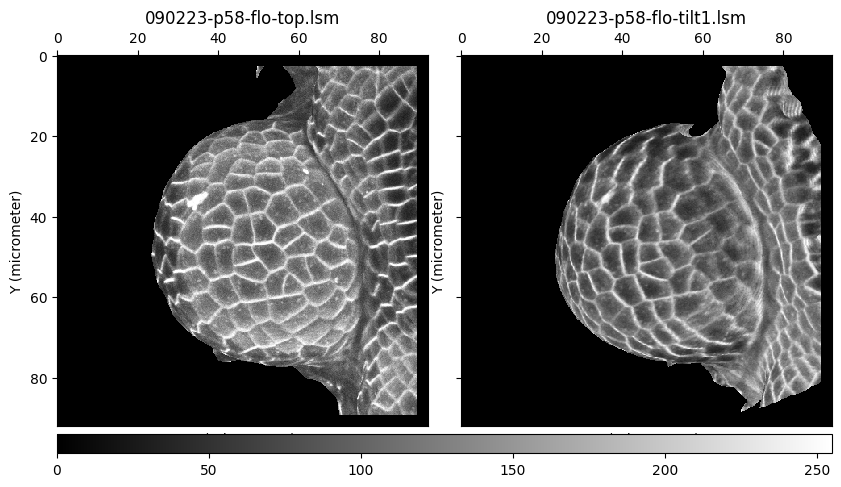

In [12]:
from timagetk.visu.mplt import grayscale_imshow
_ = grayscale_imshow([ref_proj, reg_proj])

## Refining the registration

In [13]:
rigid_trsf = blockmatching(flo_img, ref_img, template_img=ref_img, method='rigid', left_trsf=rigid_init_trsf)

2022-10-06 11:43:07,596 - timagetk.algorithms.blockmatching - 290 - INFO - RIGID registration with a 'left' initialisation matrix
 - processing level # 4          
    - Iteration #  1     Level # 4     Size   32x  32x  32
    - Iteration #  2     Level # 4     Size   32x  32x  32
    - Iteration #  3     Level # 4     Size   32x  32x  32
    - Iteration #  4     Level # 4     Size   32x  32x  32
    - Iteration #  5     Level # 4     Size   32x  32x  32
    - Iteration #  6     Level # 4     Size   32x  32x  32
    - Iteration #  7     Level # 4     Size   32x  32x  32
    - Iteration #  8     Level # 4     Size   32x  32x  32
    - Iteration #  9     Level # 4     Size   32x  32x  32
    - Iteration # 10     Level # 4     Size   32x  32x  32

 - processing level # 3          
    - Iteration #  1     Level # 3     Size   64x  64x  59
    - Iteration #  2     Level # 3     Size   64x  64x  59
    - Iteration #  3     Level # 3     Size   64x  64x  59
    - Iteration #  4     Level # 3

In [14]:
rigid_trsf = compose_trsf([rigid_init_trsf, rigid_trsf], template_img=ref_img)
registered_image = apply_trsf(flo_img, trsf=rigid_trsf, template_img=ref_img, interpolation='linear')

In [15]:
reg_proj, reg_alti = image_surface_projection(registered_image, threshold=np.percentile(registered_image, 75), orientation=1)

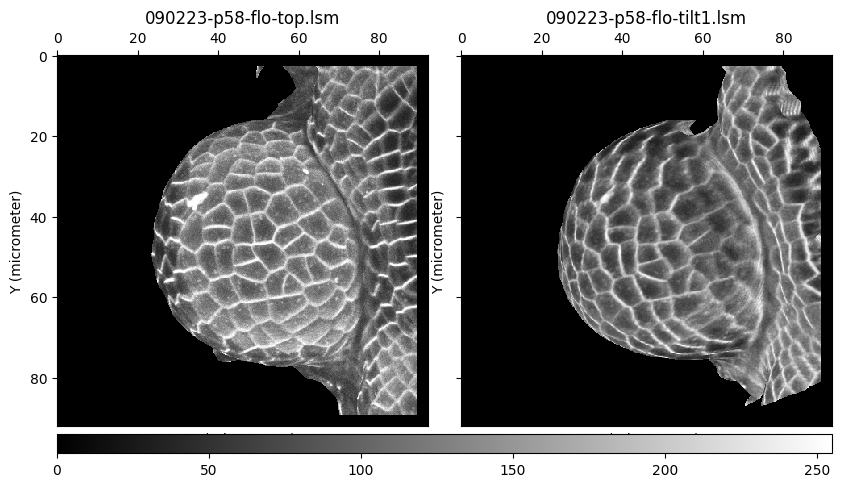

In [16]:
from timagetk.visu.mplt import grayscale_imshow
_ = grayscale_imshow([ref_proj, reg_proj])